# **Obtener** **Coordenadas**

In [7]:
import pandas as pd

archivo = '/content/sample_data/Direcciones.csv'

datos = pd.read_csv(archivo, skiprows=0)

datos

,Menú,Dirección,Comuna
0,Oslo,Santa rosa 455,Santiago
1,Roma,Carlos Davila 8353,San Ramón
2,Oslo,"Avenida el parque 1641, Casa 65",Chicauma
3,Oslo,Av. Américo Vespucio 1551,Quilicura
4,Tabla 1 metro,Orinoco 99 depto 302,Las Condes
...,...,...,...
72,Barcelona,Lo ovalle 275,Quilicura
73,Barcelona,Lo ovalle 275,Quilicura
74,Barcelona,"Marchant Pereira 1945, depto 1204L",Providencia
75,Orlando,Matilde Salamanca 959 depto 304,Providencia


In [20]:
direccion['total'] = datos['Dirección'] + ',' + datos['Comuna']
direccion['total'][0]

'Santa rosa 455,Santiago'

In [22]:
from geopy import Bing

g = Bing(api_key='AnNqiMPT9FtmlHcgTKK0T5Osz6bKS3DCGMyPhiVCpxeipdNGnG2eMtxD1zAmCESR')
l = g.geocode(direccion[total][0])

lat = l.raw['point']['coordinates'][0]
long = l.raw['point']['coordinates'][1]

print(lat,long)

-33.4498529 -70.6444209


# **MODELO**

In [ ]:
class Node:
    def __init__(self, index, demand, serv_time, time_window, lat, long):
        self.index = index
        self.demand = demand
        self.serv_time = serv_time
        self.time_window = time_window
        self.lat = lat
        self.long = long

    def __index__(self):
        return self.index

    def __hash__(self):
        return self.index

    def __repr__(self):
        return f"Customer <{self.index}>"

## Instancia de VRPTW
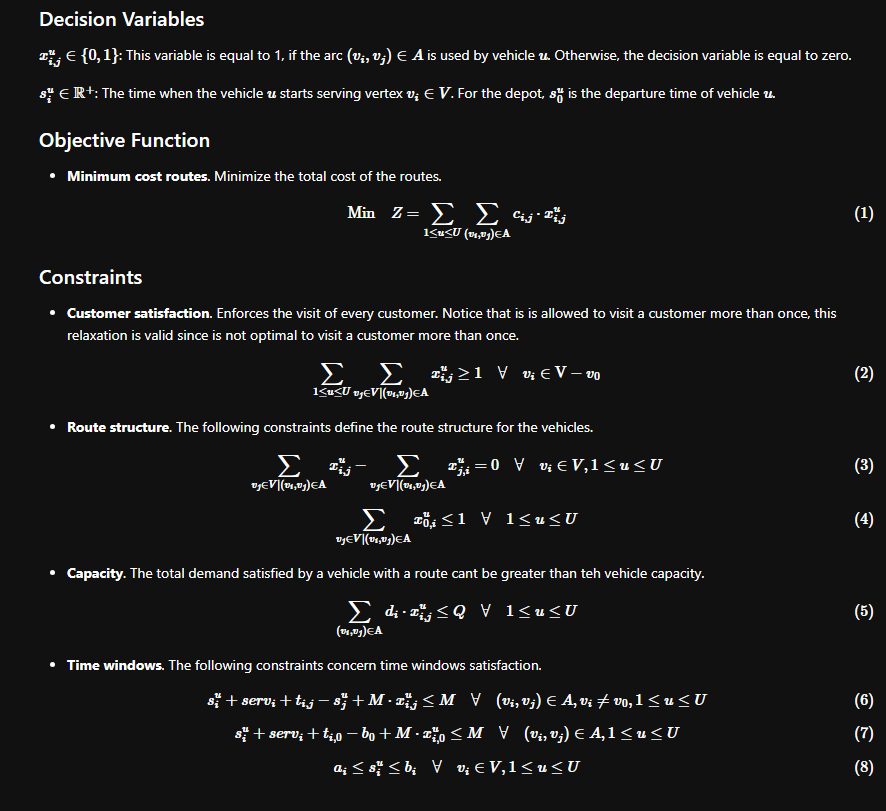


In [ ]:
from docplex.mp.model import Model

def build_VRPTW_problem(capacity, nodes, times, vehicles,**kwargs):

    #Parameters
    customers = [cstmrs for cstmrs in nodes if cstmrs.index != 0]   #todos los clientes menos el deposito
    #Big M
    bigM = 1000  #modelar restricciones

    #Model declaration
    m = Model(name = 'VRPTW', **kwargs)

    #----- Variables de decision
    #Arc covered by vehicle
    m.x_var = m.binary_var_cube(vehicles,nodes,nodes, name= 'route') #variable binaria indexada en 3 elementos
    #Start time for the service of a customer
    m.s_var = m.continuous_var_matrix(vehicles, nodes, name = 'service_time') #variable continua

    #----- Constraints -----  RESTRICCIONES    TODO ESTO SALE EN LA EXPLICACION DEL MODELO
    #Customer satisfaction
    m.covering_cts = []   #LISTA RESTRICCIONES SATISFACCION DEL CLIENTE
    for i in customers:
        cust_satisf_ct = m.sum(
            m.x_var[u,i,j] for j in nodes for u in vehicles)>= 1
        cust_satisf_ct.name = 'customer_satisf_{0!s}'.format(i.index)
        m.covering_cts.append(cust_satisf_ct)

    m.add_constraints(m.covering_cts)

    #Route structure  ESTRUCTURA DE LA RUTA
    m.flow_cts = []
    for i in nodes:
        for u in vehicles:
            flow_ct = (m.sum(m.x_var[u,i,j] for j in nodes) -
                m.sum(m.x_var[u,j,i] for j in nodes)) == 0
            flow_ct.name = 'flow_constraint_{0!s}_{1!s}'.format(i.index,u)
            m.flow_cts.append(flow_ct)

    for u in vehicles:
        flow_ct = m.sum(m.x_var[u,nodes[0],i] for i in nodes) <= 1
        flow_ct.name = 'flow_constraint_{0!s}_{1!s}_origin'.format(nodes[0].index,u)
        m.flow_cts.append(flow_ct)

    m.add_constraints(m.flow_cts)

    #Vehicle capacity   CAPACIDAD VEHICULOS
    m.capacity_cts = []
    for u in vehicles:
        capacity_ct = m.sum(nodes[i].demand * m.x_var[u,i,j] for i in nodes for j in nodes) <= capacity
        capacity_ct.name = 'capacity_vehicle{0!s}'.format(u)
        m.capacity_cts.append(capacity_ct)

    m.add_constraints(m.capacity_cts)

    #Time windows
    m.time_window_cts = []
    for i in nodes:
        for j in customers:
            for u in vehicles:
                time_window_ct = m.s_var[u,i] + i.serv_time + times[i.index][j.index] - m.s_var[u,j] + bigM*m.x_var[u,i,j] <= bigM
                time_window_ct.name = 'time_window_{0!s}_{1!s}_{2!s}'.format(u,i.index,j.index)
                m.time_window_cts.append(time_window_ct)

    for i in customers:
        for u in vehicles:
            time_window_ct = m.s_var[u,i] + i.serv_time + times[i][0] - nodes[0].time_window[1] + bigM*m.x_var[u,i,nodes[0]] <= bigM
            time_window_ct.name = 'time_window_{0!s}_{1!s}_{2!s}_arrival'.format(u,i.index,nodes[0].index)
            m.time_window_cts.append(time_window_ct)

    for i in nodes:
        for u in vehicles:
            time_window_ct_lb = i.time_window[0] <= m.s_var[u,i]
            time_window_ct_lb.name = 'time_window_lb_{0!s}'.format(i.index)
            time_window_ct_ub = i.time_window[1] >= m.s_var[u,i]
            time_window_ct_ub.name = 'time_window_ub_{0!s}'.format(i.index)
            m.time_window_cts.append(time_window_ct_lb)
            m.time_window_cts.append(time_window_ct_ub)

    m.add_constraints(m.time_window_cts)

    #----- Objective Function -----
    #Minimize the total cost
    m.total_cost = m.sum(times[i][j]*m.x_var[u,i,j] for i in nodes for j in nodes for u in vehicles)
    m.minimize(m.total_cost)

    return m